In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from pathlib import Path
import pandas as pd
import scipy


In [2]:
def extract_real_characteristics():
    """Extrae características técnicas reales de archivos JSON y NIfTI BIDS"""
    
    bids_path = Path('../../DATA/BIDS')
    image_characteristics = {}
    
    subjects_files = {
        'sub-0001': [
            ('T1w', 'sub-0001_acq-SAG3DT1ACCELERATED_T1w'),
            ('FLAIR', 'sub-0001_acq-FLAIRSAG3D_FLAIR')
        ],
        'sub-0002': [
            ('T1w', 'sub-0002_acq-SAG3DT1ACCELERATED_T1w'),
            ('FLAIR', 'sub-0002_acq-FLAIRSAG3D_FLAIR')
        ],
        'sub-0003': [
            ('T1w', 'sub-0003_acq-SAGT1SE_echo-1_T1w')
        ],
        'sub-0004': [
            ('T2w', 'sub-0004_acq-AXT2_T2w')
        ],
        'sub-0005': [
            ('T2w', 'sub-0005_acq-T2COR_T2w')
        ]
    }
    
    for subject, files in subjects_files.items():
        image_characteristics[subject] = {}
        
        for modality, filename in files:
            try:
                json_path = bids_path / subject / 'anat' / f'{filename}.json'
                nifti_path = bids_path / subject / 'anat' / f'{filename}.nii.gz'
                
                if json_path.exists():
                    with open(json_path, 'r') as f:
                        metadata = json.load(f)
                else:
                    print(f"⚠️  No se encontró archivo JSON: {json_path}")
                    metadata = {}
                
                if nifti_path.exists():
                    nifti_img = nib.load(nifti_path)
                    header = nifti_img.header
                    shape = nifti_img.shape
                    pixdim = header.get_zooms()
                else:
                    print(f"⚠️  No se encontró archivo NIfTI: {nifti_path}")
                    continue
                
                characteristics = {
                    'resolution': list(pixdim[:3]),  # mm
                    'slice_thickness': metadata.get('SliceThickness', pixdim[2] if len(pixdim) > 2 else 'N/A'),
                    'matrix_size': list(shape[:3]),
                    'spacing_between_slices': metadata.get('SpacingBetweenSlices', 'N/A'),
                    'sequence': metadata.get('SeriesDescription', 'Unknown'),
                    'protocol_name': metadata.get('ProtocolName', 'Unknown'),
                }
                
                image_characteristics[subject][modality] = characteristics
                print(f"✅ Extraídas características de {subject} - {modality}")
                
            except Exception as e:
                print(f"❌ Error procesando {subject} - {modality}: {e}")
    
    return image_characteristics

# Extraer características
print("🔍 Extrayendo características técnicas de archivos BIDS...")
image_characteristics = extract_real_characteristics()
print(f"\n📊 Total de imágenes procesadas: {sum(len(modalities) for modalities in image_characteristics.values())}")


🔍 Extrayendo características técnicas de archivos BIDS...
✅ Extraídas características de sub-0001 - T1w
✅ Extraídas características de sub-0001 - FLAIR
✅ Extraídas características de sub-0002 - T1w
✅ Extraídas características de sub-0002 - FLAIR
✅ Extraídas características de sub-0003 - T1w
✅ Extraídas características de sub-0004 - T2w
✅ Extraídas características de sub-0005 - T2w

📊 Total de imágenes procesadas: 7


In [3]:
image_characteristics

{'sub-0001': {'T1w': {'resolution': [np.float32(1.0),
    np.float32(1.0),
    np.float32(1.0002635)],
   'slice_thickness': 1,
   'matrix_size': [205, 235, 211],
   'spacing_between_slices': 1,
   'sequence': 'SAG_3D_T1_ACCELERATED',
   'protocol_name': 'SAG_3D_T1_ACCELERATED'},
  'FLAIR': {'resolution': [np.float32(1.0),
    np.float32(1.0),
    np.float32(1.0002635)],
   'slice_thickness': 1,
   'matrix_size': [205, 235, 211],
   'spacing_between_slices': 1,
   'sequence': 'FLAIR_SAG_3D',
   'protocol_name': 'FLAIR_SAG_3D'}},
 'sub-0002': {'T1w': {'resolution': [np.float32(1.0),
    np.float32(1.0),
    np.float32(1.0005522)],
   'slice_thickness': 1,
   'matrix_size': [256, 256, 211],
   'spacing_between_slices': 1,
   'sequence': 'SAG_3D_T1_ACCELERATED',
   'protocol_name': 'SAG_3D_T1_ACCELERATED'},
  'FLAIR': {'resolution': [np.float32(1.0), np.float32(1.0), np.float32(1.0)],
   'slice_thickness': 1,
   'matrix_size': [256, 256, 179],
   'spacing_between_slices': 1,
   'sequence'

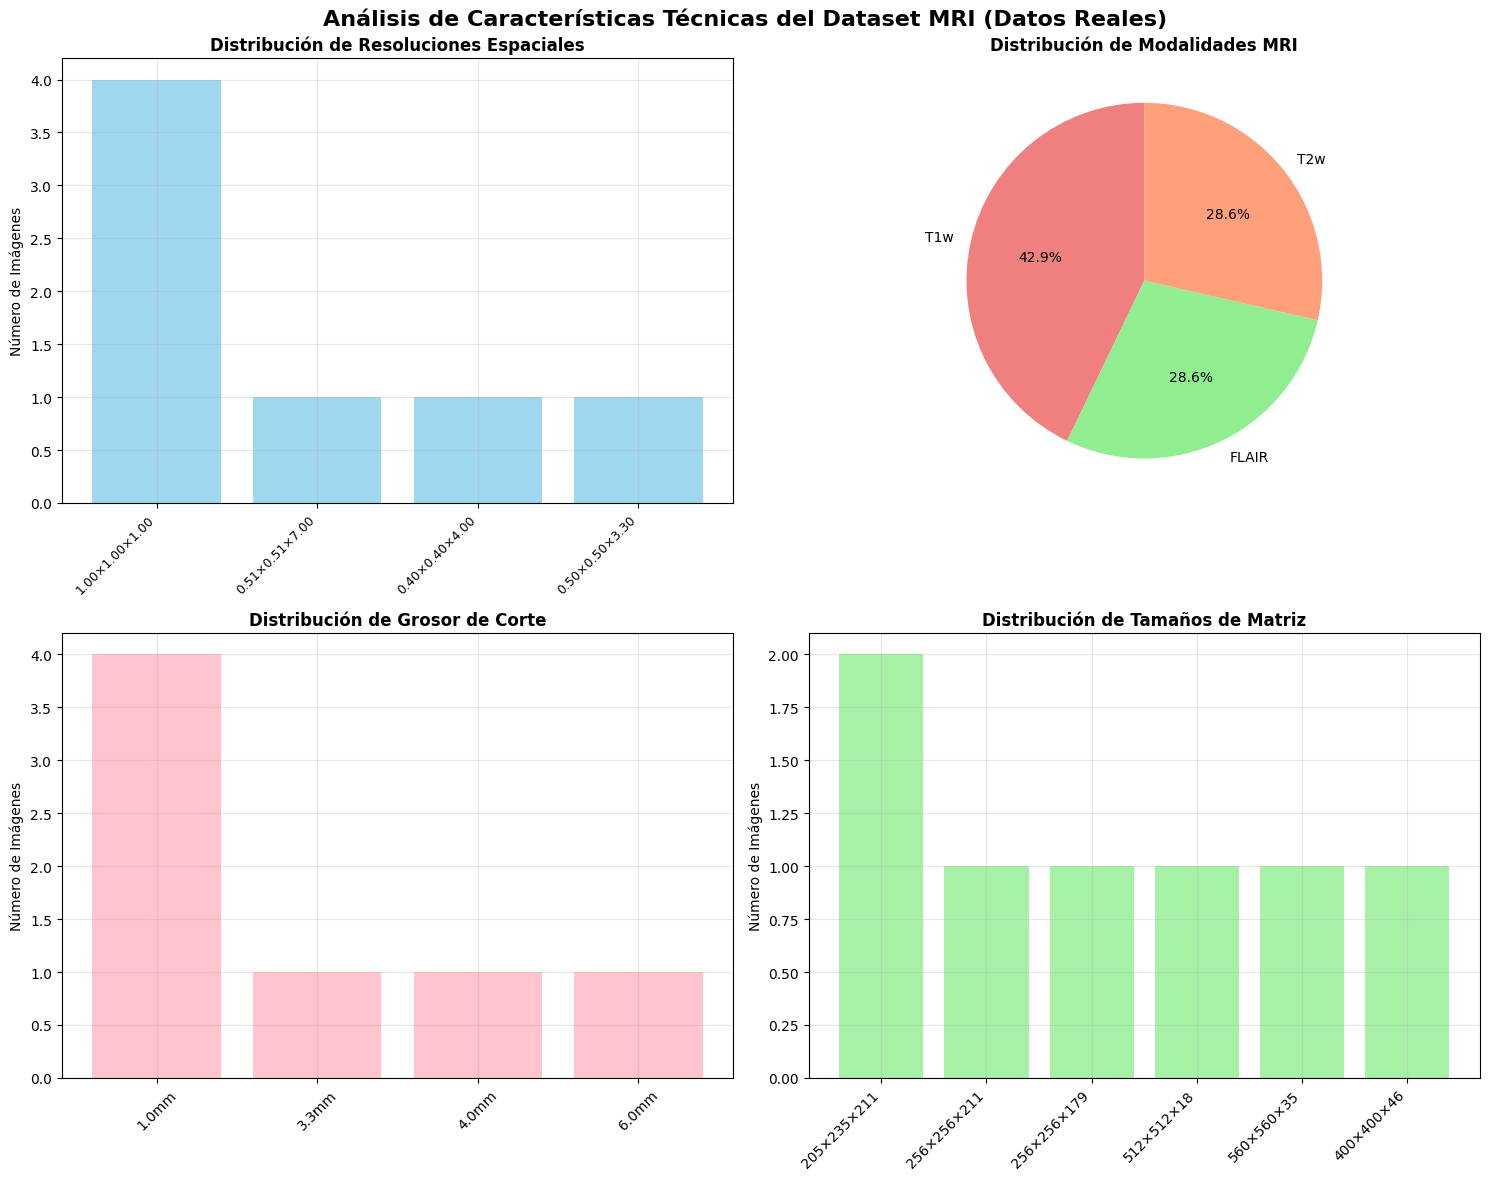

In [4]:
def create_visualizations(image_characteristics):
    """Crea visualizaciones basadas en datos reales extraídos"""
    
    # Extraer datos para las visualizaciones
    resolutions = []
    modalities = []
    thicknesses = []
    matrix_sizes = []
    
    for subject, modality_data in image_characteristics.items():
        for modality, characteristics in modality_data.items():
            # Resolución espacial (convertir a string para agrupación)
            resolution = characteristics['resolution'][:3]  # x, y, z
            resolution_str = f"{resolution[0]:.2f}×{resolution[1]:.2f}×{resolution[2]:.2f}"
            resolutions.append(resolution_str)
            
            # Modalidad
            modalities.append(modality)
            
            # Grosor de corte
            thickness = characteristics['slice_thickness']
            thicknesses.append(thickness)
            
            # Tamaño de matriz
            matrix_size = characteristics['matrix_size']
            matrix_size_str = f"{matrix_size[0]}×{matrix_size[1]}×{matrix_size[2]}"
            matrix_sizes.append(matrix_size_str)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Características Técnicas del Dataset MRI (Datos Reales)', 
                 fontsize=16, fontweight='bold')

    # Gráfico 1: Distribución de Resoluciones Espaciales
    resolution_counts = pd.Series(resolutions).value_counts()
    axes[0,0].bar(range(len(resolution_counts)), resolution_counts.values, color='skyblue', alpha=0.8)
    axes[0,0].set_xticks(range(len(resolution_counts)))
    axes[0,0].set_xticklabels(resolution_counts.index, rotation=45, ha='right', fontsize=9)
    axes[0,0].set_title('Distribución de Resoluciones Espaciales', fontweight='bold')
    axes[0,0].set_ylabel('Número de Imágenes')
    axes[0,0].grid(True, alpha=0.3)

    # Gráfico 2: Distribución de Modalidades
    modality_counts = pd.Series(modalities).value_counts()
    colors = ['lightcoral', 'lightgreen', 'lightsalmon', 'lightblue']
    axes[0,1].pie(modality_counts.values, labels=modality_counts.index, autopct='%1.1f%%', 
                colors=colors[:len(modality_counts)], startangle=90)
    axes[0,1].set_title('Distribución de Modalidades MRI', fontweight='bold')

    # Gráfico 3: Distribución de Grosor de Corte
    thickness_counts = pd.Series(thicknesses).value_counts().sort_index()
    axes[1,0].bar(range(len(thickness_counts)), thickness_counts.values, 
                color='lightpink', alpha=0.8)
    axes[1,0].set_xticks(range(len(thickness_counts)))
    axes[1,0].set_xticklabels([f'{t}mm' for t in thickness_counts.index], rotation=45)
    axes[1,0].set_title('Distribución de Grosor de Corte', fontweight='bold')
    axes[1,0].set_ylabel('Número de Imágenes')
    axes[1,0].grid(True, alpha=0.3)
    
    # Gráfico 4: Distribución de Tamaños de Matriz
    matrix_counts = pd.Series(matrix_sizes).value_counts()
    axes[1,1].bar(range(len(matrix_counts)), matrix_counts.values, 
                color='lightgreen', alpha=0.8)
    axes[1,1].set_xticks(range(len(matrix_counts)))
    axes[1,1].set_xticklabels(matrix_counts.index, rotation=45, ha='right')
    axes[1,1].set_title('Distribución de Tamaños de Matriz', fontweight='bold')
    axes[1,1].set_ylabel('Número de Imágenes')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Crear directorio plots si no existe
    plots_dir = Path('../plots')
    plots_dir.mkdir(exist_ok=True)
    
    plt.savefig('../plots/technical_characteristics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig, axes

# Crear visualizaciones con datos reales
fig, axes = create_visualizations(image_characteristics)


In [5]:
import SimpleITK as sitk
import warnings
warnings.filterwarnings('ignore')

def standardize_image_geometry(nifti_path, target_resolution=(1.0, 1.0, 1.0)):
    """
    Estandariza la resolución espacial a EXACTAMENTE target_resolution usando SimpleITK.
    SimpleITK garantiza resolución exacta y mejor calidad de resampling.
    
    Parameters:
    - nifti_path: ruta al archivo NIfTI
    - target_resolution: resolución objetivo en mm (x, y, z) - EXACTA
    
    Returns:
    - img_standardized: imagen con resolución EXACTA
    - info: información del procesamiento
    """
    
    # 1. Cargar con nibabel para obtener info original
    nib_img = nib.load(nifti_path)
    original_resolution = nib_img.header.get_zooms()[:3]
    original_shape = nib_img.shape[:3]
    
    print(f"📷 Original: {original_shape} | {[f'{r:.3f}' for r in original_resolution]} mm")
    
    # 2. Cargar con SimpleITK para resampling preciso
    sitk_img = sitk.ReadImage(str(nifti_path))
    original_spacing = sitk_img.GetSpacing()  # SimpleITK usa (x,y,z)
    original_size = sitk_img.GetSize()
    
    # 3. Configurar resampling con SimpleITK
    new_spacing = target_resolution  # (x, y, z)
    
    # Calcular nuevo tamaño manteniendo FOV
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in 
                zip(original_size, original_spacing, new_spacing)]
    
    print(f"🔄 Spacing: {original_spacing} → {new_spacing}")
    print(f"📐 Tamaño: {original_size} → {new_size}")
    
    # 4. Aplicar resampling con SimpleITK
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetDefaultPixelValue(0)
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputDirection(sitk_img.GetDirection())
    resample_filter.SetOutputOrigin(sitk_img.GetOrigin())
    resample_filter.SetInterpolator(sitk.sitkLinear)
    
    resampled_sitk = resample_filter.Execute(sitk_img)
    
    # 5. Convertir SimpleITK a nibabel manteniendo TODA la información geométrica
    resampled_array = sitk.GetArrayFromImage(resampled_sitk)
    # SimpleITK: (z,y,x) → nibabel: (x,y,z)
    resampled_array = np.transpose(resampled_array, (2, 1, 0))
    
    # 6. Crear matriz afín COMPLETAMENTE NUEVA basada en SimpleITK
    # Esto garantiza que la resolución sea exacta
    direction = resampled_sitk.GetDirection()
    origin = resampled_sitk.GetOrigin()
    spacing = resampled_sitk.GetSpacing()
    
    # Construir matriz afín desde cero usando datos de SimpleITK
    direction_matrix = np.array(direction).reshape(3, 3)
    spacing_matrix = np.diag(spacing)
    
    # Crear matriz afín 4x4
    new_affine = np.eye(4)
    new_affine[:3, :3] = direction_matrix @ spacing_matrix
    new_affine[:3, 3] = origin
    
    img_standardized = nib.Nifti1Image(resampled_array, new_affine)
    
    # 7. VERIFICAR resolución final
    final_resolution = img_standardized.header.get_zooms()[:3]
    final_spacing = resampled_sitk.GetSpacing()
    final_shape = resampled_array.shape
    
    # Debug: verificar matriz afín
    print(f"🔍 DEBUG - Matriz afín diagonal: [{new_affine[0,0]:.6f}, {new_affine[1,1]:.6f}, {new_affine[2,2]:.6f}]")
    
    info = {
        'original_shape': original_shape,
        'original_resolution': original_resolution,
        'final_shape': final_shape,
        'final_resolution': final_resolution,
        'final_spacing_sitk': final_spacing,
        'target_resolution': target_resolution,
        'resolution_exact': all(abs(f - t) < 1e-6 for f, t in zip(final_resolution, target_resolution)),
        'spacing_exact_sitk': all(abs(f - t) < 1e-6 for f, t in zip(final_spacing, target_resolution)),
        'affine_diagonal': [new_affine[0,0], new_affine[1,1], new_affine[2,2]]
    }
    
    print(f"✅ Resolución nibabel: {[f'{r:.6f}' for r in final_resolution]} mm")
    print(f"✅ Spacing SimpleITK: {[f'{s:.6f}' for s in final_spacing]} mm")
    print(f"🎯 Target exacto: {target_resolution} mm")
    print(f"✓ Resolución exacta: {info['resolution_exact']}")
    print(f"✓ Spacing exacto: {info['spacing_exact_sitk']}")
    
    if not info['resolution_exact']:
        print(f"⚠️  DIFERENCIAS resolución: {[f - t for f, t in zip(final_resolution, target_resolution)]}")
    if not info['spacing_exact_sitk']:
        print(f"⚠️  DIFERENCIAS spacing: {[f - t for f, t in zip(final_spacing, target_resolution)]}")
    
    return img_standardized, info


In [6]:
def process_bids_dataset():
    """Procesa todo el dataset BIDS aplicando estandarización geométrica"""
    
    bids_path = Path('../../DATA/BIDS')
    output_path = Path('../standardized_images')
    output_path.mkdir(exist_ok=True)
    
    # Definir archivos del dataset
    subjects_files = {
        'sub-0001': [
            ('T1w', 'sub-0001_acq-SAG3DT1ACCELERATED_T1w'),
            ('FLAIR', 'sub-0001_acq-FLAIRSAG3D_FLAIR')
        ],
        'sub-0002': [
            ('T1w', 'sub-0002_acq-SAG3DT1ACCELERATED_T1w'),
            ('FLAIR', 'sub-0002_acq-FLAIRSAG3D_FLAIR')
        ],
        'sub-0003': [
            ('T1w', 'sub-0003_acq-SAGT1SE_echo-1_T1w')
        ],
        'sub-0004': [
            ('T2w', 'sub-0004_acq-AXT2_T2w')
        ],
        'sub-0005': [
            ('T2w', 'sub-0005_acq-T2COR_T2w')
        ]
    }
    
    # Parámetros de estandarización
    TARGET_RESOLUTION = (1.0, 1.0, 1.0)  # mm
    processed_info = {}
    successful_processing = 0
    
    print("🚀 Iniciando procesamiento del dataset BIDS...")
    print(f"📋 Resolución objetivo: {TARGET_RESOLUTION} mm (FOV preservado)")
    print("="*80)
    
    for subject, files in subjects_files.items():
        processed_info[subject] = {}
        for modality, filename in files:
            try:
                nifti_path = bids_path / subject / 'anat' / f'{filename}.nii.gz'
                
                if not nifti_path.exists():
                    print(f"⚠️  Archivo no encontrado: {nifti_path}")
                    continue
                
                print(f"\n🔄 Procesando {subject} - {modality}:")
                
                img_standardized, info = standardize_image_geometry(
                    nifti_path, TARGET_RESOLUTION
                )
                
                # Guardar imagen estandarizada
                output_filename = f"{subject}_{modality}_standardized.nii.gz"
                output_filepath = output_path / output_filename
                nib.save(img_standardized, output_filepath)
                
                # Almacenar información del procesamiento
                processed_info[subject][modality] = {
                    'original_file': str(nifti_path),
                    'output_file': str(output_filepath),
                    'processing_info': info
                }
                
                successful_processing += 1
                print(f"✅ Guardado: {output_filename}")
                
            except Exception as e:
                print(f"❌ Error procesando {subject} - {modality}: {e}")
                processed_info[subject][modality] = {'error': str(e)}
    
    print("\n" + "="*80)
    print(f"🎯 Procesamiento completado: {successful_processing} imágenes estandarizadas")
    print(f"📁 Imágenes guardadas en: {output_path}")
    
    return processed_info

# Ejecutar procesamiento
processed_results = process_bids_dataset()


🚀 Iniciando procesamiento del dataset BIDS...
📋 Resolución objetivo: (1.0, 1.0, 1.0) mm (FOV preservado)

🔄 Procesando sub-0001 - T1w:
📷 Original: (205, 235, 211) | ['1.000', '1.000', '1.000'] mm
🔄 Spacing: (1.0, 1.0, 1.0002634525299072) → (1.0, 1.0, 1.0)
📐 Tamaño: (205, 235, 211) → [205, 235, 211]
🔍 DEBUG - Matriz afín diagonal: [-0.043016, -0.010623, 0.025464]
✅ Resolución nibabel: ['1.000000', '1.000000', '1.000000'] mm
✅ Spacing SimpleITK: ['1.000000', '1.000000', '1.000000'] mm
🎯 Target exacto: (1.0, 1.0, 1.0) mm
✓ Resolución exacta: True
✓ Spacing exacto: True
✅ Guardado: sub-0001_T1w_standardized.nii.gz

🔄 Procesando sub-0001 - FLAIR:
📷 Original: (205, 235, 211) | ['1.000', '1.000', '1.000'] mm
🔄 Spacing: (1.0, 1.0, 1.0002634525299072) → (1.0, 1.0, 1.0)
📐 Tamaño: (205, 235, 211) → [205, 235, 211]
🔍 DEBUG - Matriz afín diagonal: [-0.043016, -0.010623, 0.025464]
✅ Resolución nibabel: ['1.000000', '1.000000', '1.000000'] mm
✅ Spacing SimpleITK: ['1.000000', '1.000000', '1.000000'] 

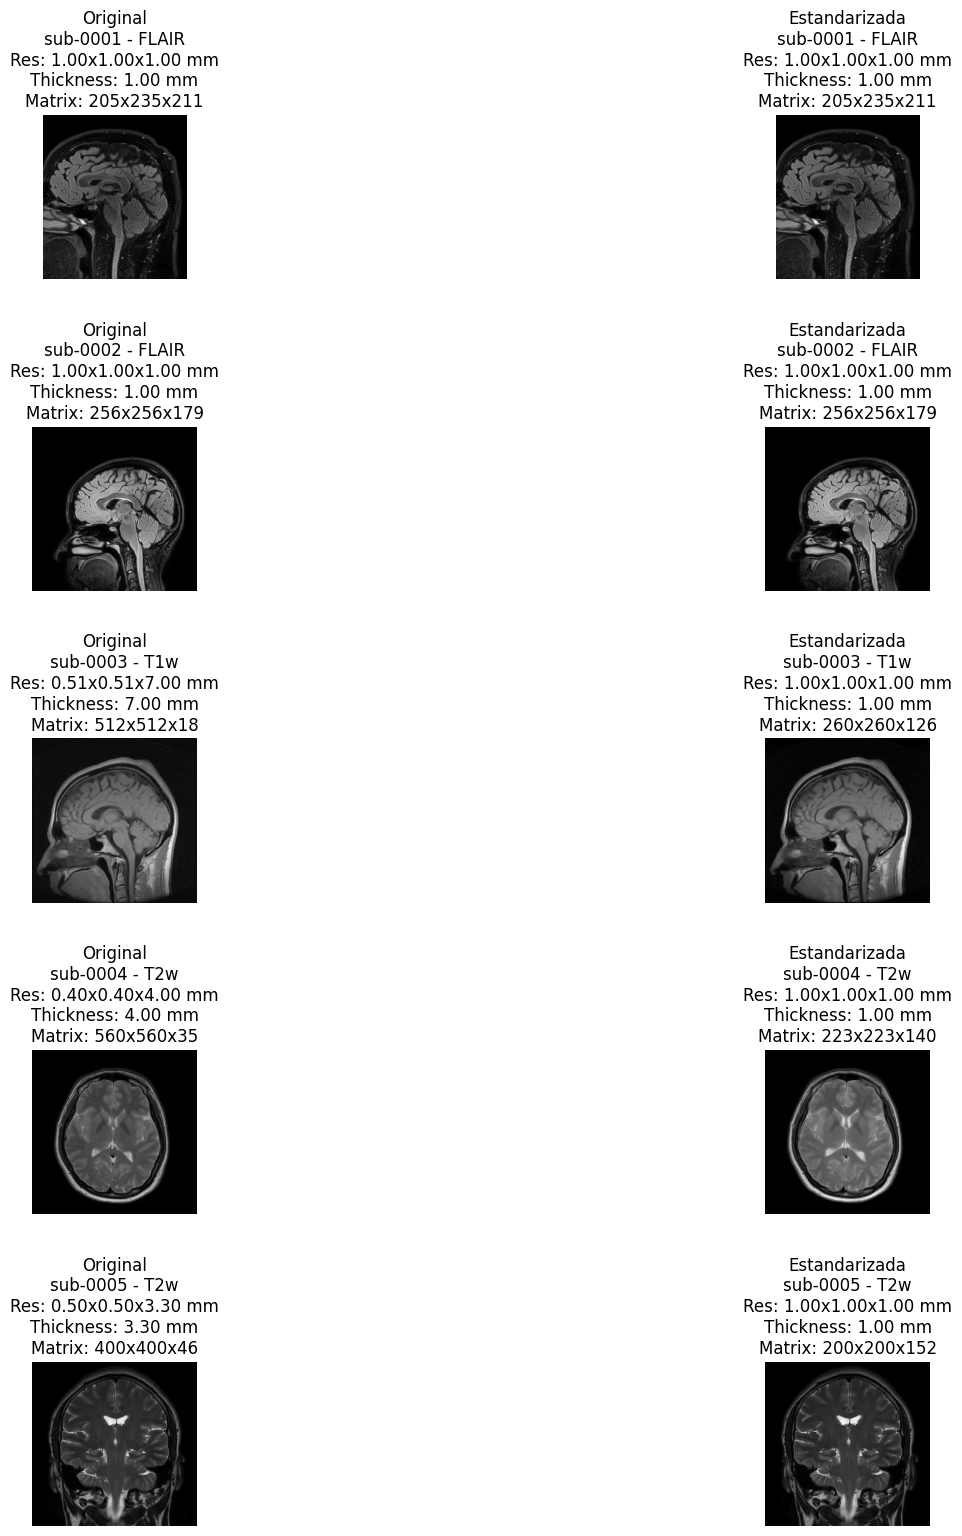

In [9]:
# Crear figura para mostrar imágenes originales vs estandarizadas
fig = plt.figure(figsize=(20, 16))  # Aumentado el tamaño de la figura

# Obtener lista de sujetos y modalidades procesadas
subjects = list(processed_results.keys())
num_subjects = len(subjects)

# Crear subplots para cada par de imágenes
for idx, subject in enumerate(subjects):
    for modality in processed_results[subject].keys():
        if 'error' not in processed_results[subject][modality]:
            # Cargar imágenes original y estandarizada
            original_img = nib.load(processed_results[subject][modality]['original_file'])
            standardized_img = nib.load(processed_results[subject][modality]['output_file'])
            
            # Obtener slice central en cada dimensión
            original_slice = original_img.get_fdata()[:, :, original_img.shape[2]//2]
            standardized_slice = standardized_img.get_fdata()[:, :, standardized_img.shape[2]//2]
            
            # Obtener parámetros directamente de las imágenes
            original_res = original_img.header.get_zooms()
            original_thickness = original_img.header.get_zooms()[2]
            original_matrix = original_img.shape
            
            standardized_res = standardized_img.header.get_zooms()
            standardized_thickness = standardized_img.header.get_zooms()[2]
            standardized_matrix = standardized_img.shape
            
            # Crear subplot para este par de imágenes
            ax1 = plt.subplot(num_subjects, 2, idx*2 + 1)
            ax1.imshow(np.fliplr(np.rot90(original_slice.T, k=2)), cmap='gray')  # Rotar 180 grados y espejo vertical
            ax1.set_title(f'Original\n{subject} - {modality}\n'
                     f'Res: {original_res[0]:.2f}x{original_res[1]:.2f}x{original_res[2]:.2f} mm\n'
                     f'Thickness: {original_thickness:.2f} mm\n'
                     f'Matrix: {original_matrix[0]}x{original_matrix[1]}x{original_matrix[2]}')
            ax1.axis('off')
            
            ax2 = plt.subplot(num_subjects, 2, idx*2 + 2)
            ax2.imshow(np.fliplr(np.rot90(standardized_slice.T, k=2)), cmap='gray')  # Rotar 180 grados y espejo vertical
            ax2.set_title(f'Estandarizada\n{subject} - {modality}\n'
                     f'Res: {standardized_res[0]:.2f}x{standardized_res[1]:.2f}x{standardized_res[2]:.2f} mm\n'
                     f'Thickness: {standardized_thickness:.2f} mm\n'
                     f'Matrix: {standardized_matrix[0]}x{standardized_matrix[1]}x{standardized_matrix[2]}')
            ax2.axis('off')

plt.tight_layout(pad=3.0)  # Aumentado el padding entre subplots
# guardar la figura en la carpeta de plots
plt.savefig('../plots/standardized_images.png')
plt.show()


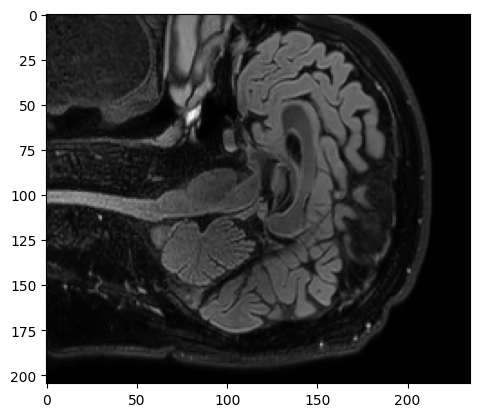

In [8]:
rel_path = '../standardized_images/sub-0001_FLAIR_standardized.nii.gz'

# Cargar la imagen
img = nib.load(rel_path)

# Obtener los datos de la imagen
data = img.get_fdata()

# mostrar la imagen
plt.imshow(data[:, :, data.shape[2]//2], cmap='gray')
plt.show()